In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import dataset_generation
import gcm_filtering
import gcm_filters
import os
import xrft

warnings.filterwarnings("ignore")

import aerobulk
from aerobulk import noskin

importlib.reload(dataset_generation)
from dataset_generation import preprocess_data, filter_inputs_dataset, compute_heatflux

In [2]:
from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=4, threads_per_worker=2)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/panalluri/proxy/8787/status,
Dashboard: /user/panalluri/proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 125.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34045,Workers: 4
Dashboard: /user/panalluri/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 125.80 GiB
Comm: tcp://127.0.0.1:37585,Total threads: 2
Dashboard: /user/panalluri/proxy/35007/status,Memory: 31.45 GiB
Nanny: tcp://127.0.0.1:38029,


# Generate coupled dataset

In [5]:
%%time
ds_merged = preprocess_data()
ds_merged

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind
CPU times: user 22.1 s, sys: 1.07 s, total: 23.1 s
Wall time: 28 s


<xarray.Dataset>
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    dxt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

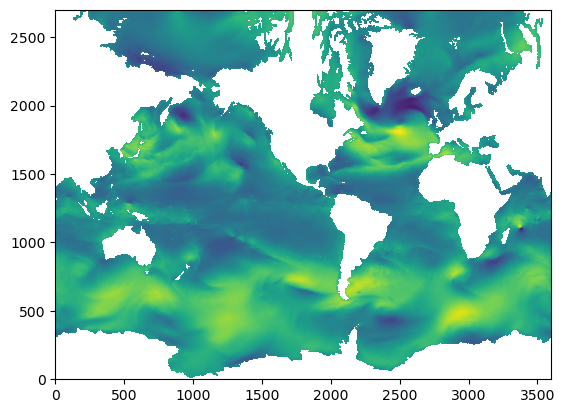

In [6]:
plt.pcolor(ds_merged.u_relative.isel(time=0))

# Filter dataset

In [ ]:
%%time
print("Filtering model")
ds_out_50 = filter_inputs_dataset(ds_merged, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian', t_range=(0,2))
ds_out_50.load()

Filtering model
CPU times: user 30.1 s, sys: 12.4 s, total: 42.5 s
Wall time: 3min 9s


<xarray.Dataset>
Dimensions:       (time: 2, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 0181-01-02 12:00:00
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    dxt           (yt_ocean, xt_ocean) float64 1.719e+03 1.719e+03 ... 4.697e+03
    dyt           (yt_ocean, xt_ocean) float64 4.697e+03 4.697e+03 ... 7.804
    geolat_t      (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    geolon_t      (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ht            (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    kmt           (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    wet           (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    area_t        (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Data variables:
    slp           (time, yt_ocean, xt_ocean) float64 nan nan nan ... nan nan nan
    v_ref         (time, yt_ocean, xt_ocean) float64 nan nan nan ... nan nan nan
    u_ref         (time, yt_ocean, xt_ocean) float64 nan nan nan ... nan nan nan
    t_ref         (time, yt_ocean, xt_ocean) float64 nan nan nan ... nan nan nan
    q_ref         (time, yt_ocean, xt_ocean) float64 nan nan nan ... nan nan nan
    wind          (time, yt_ocean, xt_ocean) float64 nan nan nan ... nan nan nan
    rh_ref        (time, yt_ocean, xt_ocean) float64 nan nan nan ... nan nan nan
    surface_temp  (time, yt_ocean, xt_ocean) float64 nan nan nan ... nan nan nan
    u_ocean       (time, yt_ocean, xt_ocean) float64 nan nan nan ... nan nan nan
    v_ocean       (time, yt_ocean, xt_ocean) float64 nan nan nan ... nan nan nan
    u_relative    (time, yt_ocean, xt_ocean) float64 nan nan nan ... nan nan nan
    v_relative    (time, yt_ocean, xt_ocean) float64 nan nan nan ... nan nan nan
Attributes:
    filter_scale:  50
    filter_type:   gaussian

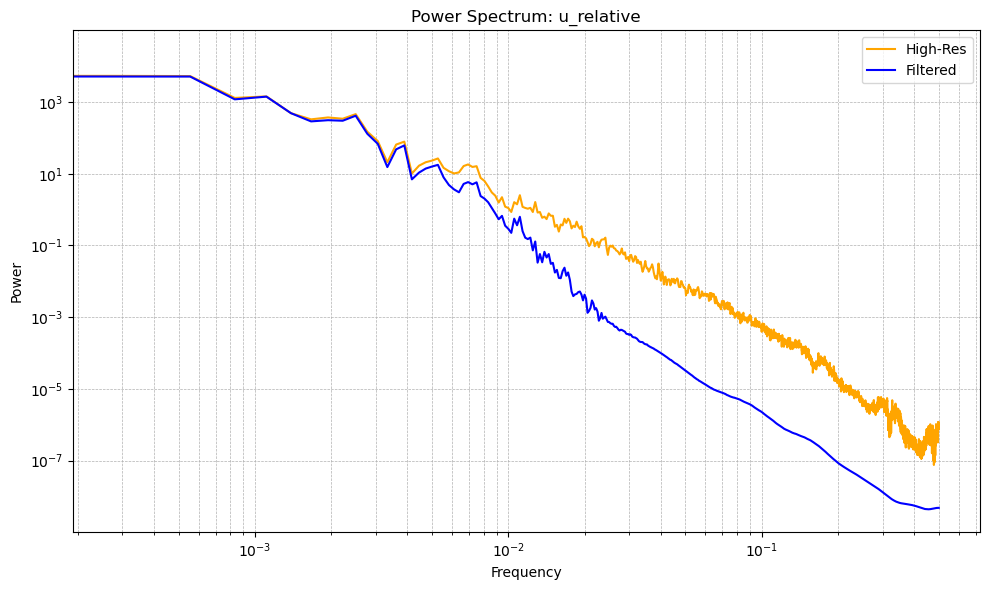

In [8]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(ds_merged.u_relative.shape[-2]),
    'xt_ocean': range(ds_merged.u_relative.shape[-1])
}

# Compute averaged power spectra across samples
sample_LR = xr.DataArray(ds_out_50.u_relative.isel(time=0), dims=dims, coords=coords).chunk({'xt_ocean': -1})
ps_LR = xrft.power_spectrum(sample_LR, dim='xt_ocean', window=True).mean(dim='yt_ocean')

sample_HR = xr.DataArray(ds_merged.u_relative.isel(time=0), dims=dims, coords=coords).chunk({'xt_ocean': -1})
ps_HR = xrft.power_spectrum(sample_HR, dim='xt_ocean', window=True).mean(dim='yt_ocean')

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_HR.freq_xt_ocean, ps_HR, label='High-Res', color='orange')
plt.plot(ps_LR.freq_xt_ocean, ps_LR, label='Filtered', color='blue')

# Configure plot
plt.title("Power Spectrum: u_relative")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


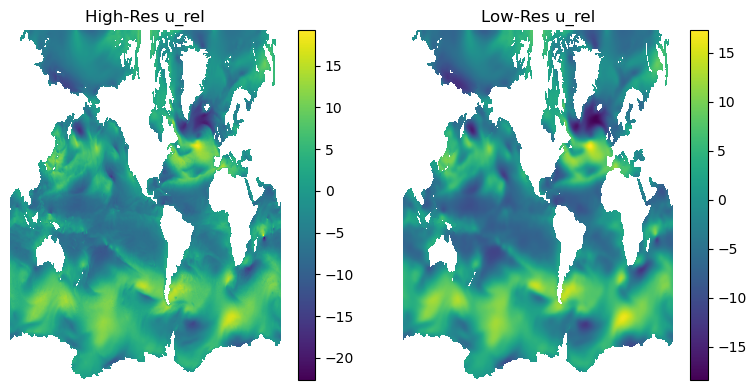

In [9]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjusted figure size

# Plot the high-resolution data
im1 = axes[0].pcolor(ds_merged.u_relative.isel(time=0))
axes[0].set_title("High-Res u_rel")
axes[0].axis('off')  # Turn off the axes
fig.colorbar(im1, ax=axes[0], orientation='vertical')

# Plot the low-resolution data
im2 = axes[1].pcolor(ds_out_50.u_relative.isel(time=0))
axes[1].set_title("Low-Res u_rel")
axes[1].axis('off')  # Turn off the axes
fig.colorbar(im2, ax=axes[1], orientation='vertical')

# Add space between subplots
plt.subplots_adjust(wspace=20)  # Increase space between plots

# Adjust layout to center the plots
plt.tight_layout()

# Show the plot
plt.show()

# Flux calculations

In [ ]:
%%time
heatflux_data = compute_heatflux(ds_merged.isel(time=slice(0,2)), ds_out_50, algo='ecmwf', zt=2, zu=10)
heatflux_data.load()

CPU times: user 1min 28s, sys: 20.1 s, total: 1min 48s
Wall time: 3min 15s


<xarray.Dataset>
Dimensions:        (time: 2, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time           (time) object 0181-01-01 12:00:00 0181-01-02 12:00:00
  * xt_ocean       (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean       (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    dxt            (yt_ocean, xt_ocean) float64 1.719e+03 ... 4.697e+03
    dyt            (yt_ocean, xt_ocean) float64 4.697e+03 4.697e+03 ... 7.804
    geolat_t       (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    geolon_t       (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ht             (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    kmt            (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    wet            (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    area_t         (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Data variables:
    heatflux_hr    (time, yt_ocean, xt_ocean) float64 nan nan nan ... nan nan
    heatflux_lr    (time, yt_ocean, xt_ocean) float64 nan nan nan ... nan nan
    heatflux_diff  (time, yt_ocean, xt_ocean) float64 nan nan nan ... nan nan

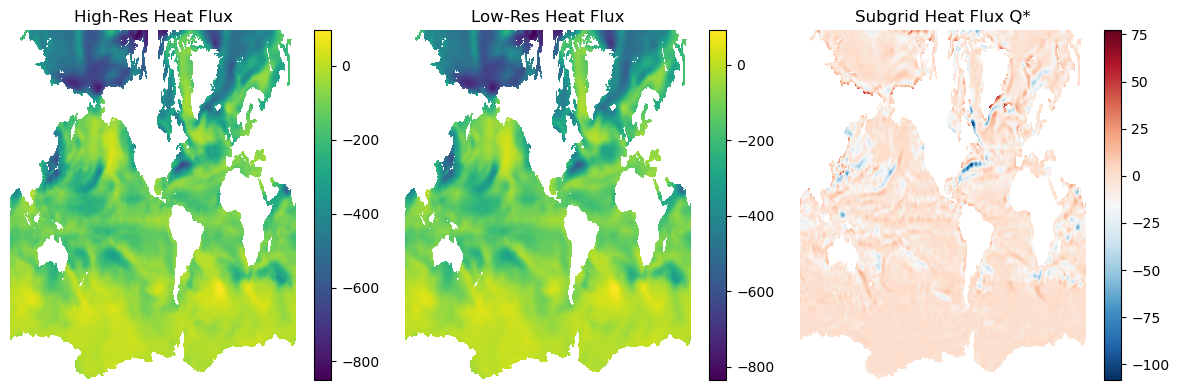

In [12]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot high-res u_relative
im1 = axes[0].pcolor(heatflux_data.heatflux_hr.isel(time=0))
axes[0].set_title("High-Res Heat Flux")
axes[0].axis("off")
fig.colorbar(im1, ax=axes[0], orientation="vertical")

# Plot low-res u_relative
im2 = axes[1].pcolor(heatflux_data.heatflux_lr.isel(time=0))
axes[1].set_title("Low-Res Heat Flux")
axes[1].axis("off")
fig.colorbar(im2, ax=axes[1], orientation="vertical")

# Plot difference with separate color scale
im3 = axes[2].pcolor(heatflux_data.heatflux_diff.isel(time=0), cmap="RdBu_r")
axes[2].set_title("Subgrid Heat Flux Q*")
axes[2].axis("off")
fig.colorbar(im3, ax=axes[2], orientation="vertical")

# Adjust spacing
plt.tight_layout()
plt.show()
